In [0]:
def dataset_download_organise_gdrive():
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd "gdrive/My Drive"
  %cd 'Capstone data'
  !wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Annotations_Train_mscoco.zip
  !wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Questions_Train_mscoco.zip
  !wget http://images.cocodataset.org/zips/train2014.zip
  !unzip Annotations_Train_mscoco.zip -d train
  !unzip Questions_Train_mscoco.zip -d train
  !unzip train2014.zip -d train

{}

In [3]:
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import time

from vqa import VQA
import nltk
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/paperspace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
tf.__version__

'1.13.1'

# Text and Image Processing for train data

### Text Processing

In [5]:
from sklearn.preprocessing import LabelEncoder
#enc = OneHotEncoder(handle_unknown='ignore')
label_encoder = LabelEncoder()

def text_processing(questions_file,answers_file,data_type,my_annotation_file):
  
    if os.path.exists(my_annotation_file):
        print("annotations found")
        annotations=pd.read_csv(my_annotation_file)
    else:
        train_answer_file = "./train/mscoco_train2014_annotations.json"
        train_question_file = "./train/MultipleChoice_mscoco_train2014_questions.json",
        vqa = VQA("./train/mscoco_train2014_annotations.json" , "./train/MultipleChoice_mscoco_train2014_questions.json")
        vqa.filter_by_ques_len(30)
        vqa.filter_by_ans_len(10)
        
        question_ids = vqa.getQuesIds(ansTypes="yes/no")
        
        answer_types = [vqa.qa[k]['answer_type'] for k in question_ids]
        image_ids = [vqa.qa[k]['image_id'] for k in question_ids]
        image_files = [os.path.join("./train/train2014", "COCO_train2014"+"_000000"+("%06d" %k)+".jpg")
                       for k in image_ids]
        questions = [vqa.qqa[k]['question'] for k in question_ids]
        answers = [vqa.qa[k]['best_answer'] for k in question_ids]
          
  
  
        annotations = pd.DataFrame({'question_id': question_ids,
                                    'image_id': image_ids,
                                    'image_file': image_files,
                                    'question': questions,
                                    'answer': answers,
                                     'answer_type':answer_types})
        annotations.to_csv(my_annotation_file)
  
  
  
    all_captions = []
    for annot in annotations["question"]:
        capt = "<start> " + annot + " <end>"
        all_captions.append(capt)


    #   all_answers = []
    #   for answer in annotations["answer"]:
    #     ans = "<start> " + answer + " <end>"
    #     all_answers.append(ans)

    top_k = 5000
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, 
                                                  oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

    tokenizer.fit_on_texts(all_captions)
    tokenizer.word_index['<pad>'] = 0
    train_seqs = tokenizer.texts_to_sequences(all_captions)
    questions_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

#     answer_vector = np.expand_dims(annotations["answer"],axis =1)
#     #answer_vector = np.reshape(annotations["answer"],(-1,1))
#     print(answer_vector)
    #   answer_vector = tokenizer.texts_to_sequences(all_answers)
    #   answer_vector=tf.keras.preprocessing.sequence.pad_sequences(answer_vector, padding='post')
    
#     tokenizer2 = tf.keras.preprocessing.text.Tokenizer(num_words=3, 
#                                                   oov_token="<unk>", 
#                                                   filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
#     tokenizer2.fit_on_texts(annotations["answer"])
#     answer_vector =  tokenizer2.texts_to_sequences(annotations["answer"])
#     answer_vector= enc.fit_transform(answer_vector).toarray()
    
    answer_vector = []
    for i in annotations["answer"]:
        if i == "yes":
            answer_vector.append(1)
        else:
            answer_vector.append(0)
            
    
    image_name_vector = list(annotations["image_file"])
    questions_vector = np.array(questions_vector)
    image_name_vector = list(image_name_vector)
    
    print(len(image_name_vector))
    print(len(questions_vector))
    print(image_name_vector[:2])
    
    return tokenizer,image_name_vector,questions_vector,answer_vector
  
tokenizer,image_name_vector,questions_vector,answer_vector = text_processing("./train/mscoco_train2014_annotations.json",
                                                                            "./train/MultipleChoice_mscoco_train2014_questions.json",
                                                                            "./train/train2014","./train/my_mcq_annotation_file")


  

annotations found
95163
95163
['./train/train2014/COCO_train2014_000000487025.jpg', './train/train2014/COCO_train2014_000000078077.jpg']


In [6]:

# questions_vector = np.array(questions_vector)
# image_name_vector = list(image_name_vector)

print(len(answer_vector))
print(len(image_name_vector))
print(len(questions_vector))
print(type(image_name_vector))
print(type(questions_vector))
print(type(answer_vector))
print(questions_vector[1:3])
print(image_name_vector[1:3])
print(answer_vector[34])
print((answer_vector[:10]))



95163
95163
95163
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
[[  2   4   7   6 203  42   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  2   4   5  53 703  11  21 761  13   1   1   3   0   0   0   0   0   0
    0   0   0   0   0   0]]
['./train/train2014/COCO_train2014_000000078077.jpg', './train/train2014/COCO_train2014_000000501867.jpg']
1
[1, 0, 0, 1, 1, 0, 1, 1, 0, 1]


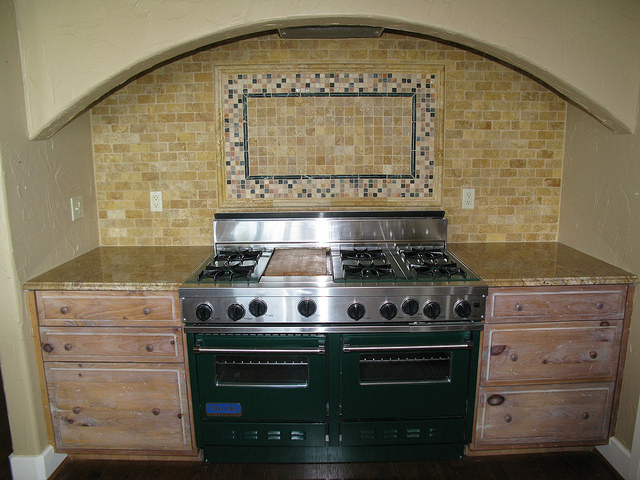

In [7]:
from IPython.display import display, Image
display(Image(filename=image_name_vector[37]))


In [8]:
tokenizer.sequences_to_texts(questions_vector[37:38])

['<start> is this area well decorated <end> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>']

In [9]:
answer_vector[37]

1

In [10]:
# c = 0
# del_indices = []
# for i,an in enumerate(answer_vector):
#     if len(an) > 2:
#         c +=1
#         del_indices.append(i)
        
        
        
# print(c)

In [11]:
# print(answer_vector[34])
# answer_vector[105111]


In [12]:
# image_name_vector = np.delete(image_name_vector,del_indices,0)
# questions_vector = np.delete(questions_vector,del_indices,0)
# answer_vector = np.delete(answer_vector,del_indices,0)

In [13]:
answer_vector = list(answer_vector)
questions_vector = np.array(questions_vector)
image_name_vector = list(image_name_vector)
print(len(answer_vector))
print(len(image_name_vector))
print(len(questions_vector))
print(type(image_name_vector))
print(type(questions_vector))
print(type(answer_vector))
print(questions_vector[1:3])
print(image_name_vector[1:3])
print(answer_vector[1])

95163
95163
95163
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
[[  2   4   7   6 203  42   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  2   4   5  53 703  11  21 761  13   1   1   3   0   0   0   0   0   0
    0   0   0   0   0   0]]
['./train/train2014/COCO_train2014_000000078077.jpg', './train/train2014/COCO_train2014_000000501867.jpg']
0


# Image preprocessing for Train data

In [14]:
n_train_samples = 80000 

In [15]:
image_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


Instructions for updating:
Colocations handled automatically by placer.


In [16]:
def load_image_1(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Image conversion to .npy files
The below code builds numpy files of the image files. The image files are passed through an existing inception model to obtain features which are then saved as a numpy file with ".npy" added to the name of the image.
The code is commented because the image conversion is needed only once. After that we can access those numpy files 

In [17]:
#feel free to change the batch_size according to your system configuration

# image_dataset = tf.data.Dataset.from_tensor_slices(
#                                 image_name_vector[:n_train_samples]).map(load_image_1).batch(16)

# for img, path in tqdm(image_dataset):
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features, 
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         np.save(path_of_feature, bf.numpy())

The following codes removes all the numpy files created by the previous cell in the train/train2014/ folder. So that  we can create new numpy files again.

In [18]:
# cou = 0
# import os, shutil
# folder = './train/train2014/'
# for the_file in os.listdir(folder):
#     file_path = os.path.join(folder, the_file)
#     try:
#         if os.path.isfile(file_path) :
#             print(file_path)
#             if file_path.__contains__(".npy"):
#                 print("found")
#                 cou += 1
#                 os.unlink(file_path)
#         #elif os.path.isdir(file_path): shutil.rmtree(file_path)
#     except Exception as e:
#         print(e)


In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

units = 512
vocab_size = len(tokenizer.word_index)
# shape Tof the vector extracted from InceptionV3 is (64, 2048)
# these two variables represent that
features_shape = 2048
attention_features_shape = 64
LOG_FREQ = 18
SAVE_FREQ = 2


In [20]:
def map_func(img_name, ques):
    img_tensor = np.load(img_name.numpy().decode('utf-8')+'.npy')
    #print(img_tensor)
    return img_tensor, ques

In [21]:
def load_image_2(image_path,cap,answer_vector):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.expand_dims(img,0)
    img = image_features_extract_model(img)
    img = tf.reshape(img, (-1, img.shape[3]))
    return img,cap,answer_vector


In [22]:
image_name_vector2 = image_name_vector[:n_train_samples]
questions_vector2= questions_vector[:n_train_samples]
answer_vector2 = answer_vector[:n_train_samples]

In [26]:
img_name_train, img_name_val, ques_train, ques_val, answer_train,answer_val = train_test_split(image_name_vector2,questions_vector2,answer_vector2,
                                                                    test_size=0.2, 
                                                                    random_state=0)

In [27]:
dataset_d1 = tf.data.Dataset.from_tensor_slices((img_name_train,ques_train))
dataset_d2 = tf.data.Dataset.from_tensor_slices(answer_train)
dataset_d1 = dataset_d1.map(lambda item1, item2: tf.py_function(map_func, [item1, item2], [tf.float32, item2.dtype]), num_parallel_calls=1)
dataset = tf.data.Dataset.zip((dataset_d1,dataset_d2))

# using map to load the numpy files in parallel
# NOTE: Be sure to set num_parallel_calls to the number of CPU cores you have
# https://www.tensorflow.org/api_docs/python/tf/py_func
#dataset = dataset.map(lambda item1, item2,item3: tf.py_function(map_func, [item1, item2,item3], [tf.float32, item2.dtype,item3.dtype]), num_parallel_calls=1)
#dataset  =dataset.map(load_image)
# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).repeat()
# https://www.tensorflow.org/api_docs/python/tf/contrib/data/batch_and_drop_remainder
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
dataset = dataset.prefetch(1)

In [28]:
val_dataset_d1 = tf.data.Dataset.from_tensor_slices((img_name_val,ques_val))
val_dataset_d2 = tf.data.Dataset.from_tensor_slices(answer_val)
val_dataset_d1 = val_dataset_d1.map(lambda item1, item2: tf.py_function(map_func, [item1, item2], [tf.float32, item2.dtype]), num_parallel_calls=1)
val_dataset = tf.data.Dataset.zip((val_dataset_d1,val_dataset_d2))

# using map to load the numpy files in parallel
# NOTE: Be sure to set num_parallel_calls to the number of CPU cores you have
# https://www.tensorflow.org/api_docs/python/tf/py_func
#dataset = dataset.map(lambda item1, item2,item3: tf.py_function(map_func, [item1, item2,item3], [tf.float32, item2.dtype,item3.dtype]), num_parallel_calls=1)
#dataset  =dataset.map(load_image)
# shuffling and batching
val_dataset = val_dataset.shuffle(BUFFER_SIZE).repeat()
# https://www.tensorflow.org/api_docs/python/tf/contrib/data/batch_and_drop_remainder
val_dataset = val_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset = val_dataset.prefetch(1)

In [20]:
def gru(units):
  # If you have a GPU, we recommend using the CuDNNGRU layer (it provides a 
  # significant speedup).
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [21]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(tf.cast(features,dtype=tf.float32)) + self.W2(tf.cast(hidden_with_time_axis,dtype=tf.float32)))
    
    # attention_weights shape == (batch_size, 64, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = tf.cast(attention_weights,dtype=tf.float32) * tf.cast(features,dtype=tf.float32)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [27]:
class CNN_Encoder(tf.keras.layers.Layer):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [28]:
class RNN_Decoder_1(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder_1, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = gru(self.units)
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(1000)
    
    self.attention = BahdanauAttention(self.units)
        
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    #x = tf.concat([context_vector, x], axis=-1)
    
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    
    #x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    
#     #output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))
  

    

In [29]:
encoder = CNN_Encoder(embedding_dim)
decoder_1 = RNN_Decoder_1(embedding_dim, units, vocab_size)




In [51]:
optimizer = tf.optimizers.Adam()

ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer=optimizer, net=decoder_1)
manager = tf.train.CheckpointManager(ckpt, './models/tf_ckpts', max_to_keep=5)
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [37]:
import datetime




def loss_fn(labels, logits):
    return tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)

train_loss_avg = tf.keras.metrics.Mean(name='train_loss')
eval_loss_avg = tf.keras.metrics.Mean(name='eval_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
eval_accuracy =  tf.keras.metrics.CategoricalAccuracy('eval_accuracy')

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
# train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)



In [47]:
def train_step_out(img_tensor,annotations,answers,dec_input,hidden):
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        loss = 0
        annots_features = np.empty((BATCH_SIZE,1,units))
   
       #Decoder for the annotations
        for i in range(1, annotations.shape[1]):
                  # passing the features through the decoder
            annots, hidden, _ = decoder_1(dec_input, features, hidden)
            
            #annots = tf.reshape(annots, (-1, 1000))
            
            # using teacher forcing
            dec_input = tf.expand_dims(annotations[:, i], 1)
        #print(tf.shape(annots))
        #print("answers",tf.shape(answers))
        loss_value = loss_fn(answers,annots)
        
        #print(tf.shape(annots))
        #annots_features= np.concatenate((annots_features,annots),axis=1)
        #loss += loss_function(predictions[:, i], annots)

       

      
     
      
      #Decoder for the answers 
#       ans_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
#       for i in range(1,answers.shape[1]):
#         print(tf.shape(ans_input),tf.shape(annots_features),tf.shape(hidden))
#         ans,hidden,_ = decoder_2(ans_input,annots_features,hidden)
     
        
        # x shape == (batch_size * max_length, hidden_size)
#         ans = tf.reshape(ans, (-1, ans.shape[2]))

#         # output shape == (batch_size * max_length, vocab)
#         ans = tf.keras.layers.Dense(vocab_size)(ans)
        
           
#         loss += loss_function(answers[:, i], ans)
#         accuracy += train_accuracy(answers[:, i], ans)
#         ans_input = tf.expand_dims(answers[:, i], 1)

    
    
    train_loss_avg.update_state(loss_value)
    train_accuracy.update_state(answers,annots)
    variables =  decoder_1.variables 

    gradients = tape.gradient(loss_value, variables) 

    optimizer.apply_gradients(zip(gradients, variables))



In [73]:
def train_out(dataset,num_epochs):
    
    train_loss_list = []
    train_accuracy_list = []
    for epoch in tqdm(range(num_epochs)):
        start = time.time()
        total_loss = 0
        start_time = time.time()
        train_loss_avg.reset_states()
        train_accuracy.reset_states()
        eval_accuracy.reset_states()
        eval_loss_avg.reset_states()

        for (batch_idx, (img_tensor,annotation, answer)) in enumerate(dataset):
            #print(batch_idx)
        # initializing the hidden state for each batch
        # because the captions are not related from image to image
            hidden = decoder_1.reset_state(batch_size=annotation.shape[0])
            dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
            train_step_out(img_tensor,annotation,answer,dec_input,hidden)
        
        #           predictions_list = numpy.zeros
 
#             if batch_idx % LOG_FREQ == 0:
#                 print(f"Batch {batch_idx}, average loss is {train_loss_avg.result().numpy()}, average accuracy is {train_accuracy.result().numpy()}")
#                 with train_summary_writer.as_default():
#                     tf.summary.scalar('loss', train_loss_avg.result(), step=epoch)
#                     tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
            if batch_idx+1 % LOG_FREQ ==0:
                print('Epoch: {0}, Step : {0} Time: {1:.2f}, Train Loss: {2:.2f} Train accuracy: {2:.2f}'.format(int(ckpt.step),batch_idx+1,time.time() - start_time,train_loss_avg.result().numpy(),train_accuracy.result().numpy()))
       
        #MODEL SAVING USING CHECKPOINTS
        ckpt.step.assign_add(1)
        if int(ckpt.step) % 2 == 0:
                save_path = manager.save()
                print("Saved checkpoint for epoch {}: {}".format(int(ckpt.step), save_path))
                print('***Epoch: {0}, Time: {1:.2f}, Train Loss: {2:.2f} Train accuracy: {2:.2f}'.format(int(ckpt.step),time.time() - start_time,
                                                                                                      train_loss_avg.result().numpy(),train_accuracy.result().numpy()))
                if all(train_loss_avg.result().numpy() < i for i in train_loss_list):
                    print("$$$checkpoint: {} is the best".format(save_path))
        #SUMMARY AT THE END OF EPOCH, PLOT GRAPH NECESSITIES
        train_loss_list.append(train_loss_avg.result().numpy())
        train_accuracy_list.append(train_accuracy.result().numpy())
        print('###Epoch: {0}, Time: {1:.2f}, Train Loss: {2:.2f} Train accuracy: {2:.2f}'.format(int(ckpt.step),time.time() - start_time,train_loss_avg.result().numpy(),train_accuracy.result().numpy()))

In [74]:
train_out(dataset,4)

###Epoch: 25, Time: 2.62, Train Loss: 1.41 Train accuracy: 1.41
Saved checkpoint for epoch 26: ./models/tf_ckpts/ckpt-11
***Epoch: 26, Time: 2.66, Train Loss: 1.42 Train accuracy: 1.42
###Epoch: 26, Time: 2.66, Train Loss: 1.42 Train accuracy: 1.42
###Epoch: 27, Time: 2.60, Train Loss: 1.43 Train accuracy: 1.43
Saved checkpoint for epoch 28: ./models/tf_ckpts/ckpt-12
***Epoch: 28, Time: 2.70, Train Loss: 1.45 Train accuracy: 1.45
###Epoch: 28, Time: 2.71, Train Loss: 1.45 Train accuracy: 1.45



In [29]:

from tensorflow.python.keras.models import Sequential

from tensorflow.python.keras import layers
 



num_hidden_units_mlp = 1024
num_hidden_units_lstm = 512
img_dim = 4096
embedding_dim = 300
vocab_size = len(tokenizer.word_index)

input1 = tf.keras.layers.Input(shape=(64,2048))
input2 = tf.keras.layers.Input(shape=(None,))

image_model = layers.GlobalAveragePooling1D()(input1)
#image_model.add(Dense(img_dim,activation='relu', input_shape=image_name_vector[1:]))


# language_model = LSTM(output_dim = num_hidden_units_lstm, 
#     return_sequences=False, 
#     input_shape=(max_len, word_vec_dim))(input2)

language_model = tf.keras.layers.Embedding(vocab_size, embedding_dim)(input2)
language_model = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units_lstm,
                        return_sequences = True, recurrent_initializer='glorot_uniform'))(language_model)
language_model = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units_lstm,
                        recurrent_initializer='glorot_uniform'))(language_model)
language_model = tf.keras.layers.Dense(vocab_size)(language_model)

language_model= layers.concatenate([image_model,language_model])
#model = tf.keras.layers.Concatenate(axis=1)([image_model,language_model])
language_model = tf.keras.layers.Dense(num_hidden_units_mlp, kernel_initializer='uniform',activation='tanh')(language_model)

language_model = tf.keras.layers.Dropout(0.5)(language_model)
language_model = tf.keras.layers.Dense(num_hidden_units_mlp, kernel_initializer='uniform',activation='tanh')(language_model)

language_model = tf.keras.layers.Dropout(0.5)(language_model)
output = tf.keras.layers.Dense(2,activation="softmax")(language_model)

# model = Sequential()
# model.add(Merge([language_model, image_model], 
#     mode='concat', concat_axis=1))
# model.add(Dense(num_hidden_units_mlp, init='uniform'))
# model.add(Activation('tanh')
# model.add(Dropout(0.5))
# model.add(Dense(num_hidden_units_mlp, init='uniform'))
# model.add(Activation('tanh')
# model.add(Dropout(0.5))
# model.add(Dense(nb_classes))
# model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model = tf.keras.Model(inputs = [input1,input2],outputs = [output])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    3166800     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 1024)   3330048     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 2048)     0                                       

In [30]:
def gen():
    with tf.Session() as sess:
        iterator= dataset.make_one_shot_iterator()
        next_x,next_y = iterator.get_next()
        while True:
            x_batch = sess.run(next_x)
            y_batch = sess.run(next_y)
            yield x_batch, y_batch

In [31]:
def val_gen():
    with tf.Session() as sess:
        iterator= val_dataset.make_one_shot_iterator()
        next_x,next_y = iterator.get_next()
        while True:
            x_batch = sess.run(next_x)
            y_batch = sess.run(next_y)
            yield x_batch, y_batch

In [36]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [35]:
filepath = "./models/model-ep{epoch:03d}-loss{val_loss:.3f}.h5"
checkpoint_call_back = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,mode='min',
                                                                        period=1)

In [34]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False)

In [33]:
ten_call_back = tf.keras.callbacks.TensorBoard(
  log_dir='./logs/keras',
  histogram_freq=0,  # How often to log histogram visualizations
  embeddings_freq=0,  # How often to log embedding visualizations
  update_freq = 64*300 )  # How often to write logs (default: once per epoch)


In [38]:
model = tf.keras.models.load_model("./models/model-ep002-loss0.671.h5",compile=True)

In [39]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
history = model.fit_generator(gen() ,steps_per_epoch=700,validation_data = val_gen(),validation_steps = 125,epochs = 5 ,callbacks=[ten_call_back,checkpoint_call_back,early_stop],verbose=1)

Epoch 1/5
 42/700 [>.............................] - ETA: 22:18 - loss: 0.7205 - acc: 0.5577

KeyboardInterrupt: 

In [46]:
model.save("./models/model-ep005-loss0.7417.h5")

In [49]:
history = model.fit_generator(gen() ,steps_per_epoch=700,validation_data = val_gen(),validation_steps = 125,epochs = 5 ,callbacks=[ten_call_back,checkpoint_call_back,early_stop],verbose=1)

Epoch 1/5
443/700 [=================>............] - ETA: 6:29 - loss: 9.6889 - acc: 0.3982

KeyboardInterrupt: 

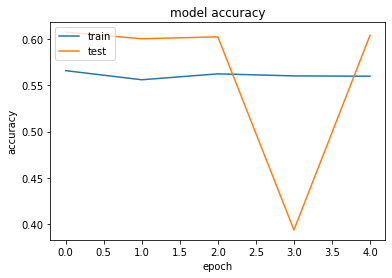

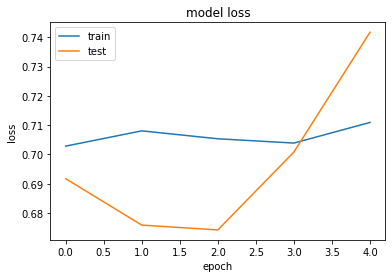

In [51]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
history_1 = history

In [ ]:
history_2 = model.fit_generator(gen() ,steps_per_epoch=700,validation_data = val_gen(),validation_steps = 125,epochs = 5 ,callbacks=[ten_call_back,checkpoint_call_back,early_stop],verbose=1)

Epoch 1/5
699/700 [============================>.] - ETA: 1s - loss: 0.7084 - acc: 0.5552WARNING:tensorflow:The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6ad99b5f60>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f6cb0086eb8>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), (64,)), types: ((tf.float32, tf.int32), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


125/125 [==============================] - 101s 811ms/step - loss: 0.7715 - acc: 0.3887

Epoch 00001: val_loss did not improve from 0.67423
700/700 [==============================] - 1150s 2s/step - loss: 0.7085 - acc: 0.5550 - val_loss: 0.7715 - val_acc: 0.3887
Epoch 2/5
125/125 [==============================] - 98s 780ms/step - loss: 0.6714 - acc: 0.6053

Epoch 00002: val_loss improved from 0.67423 to 0.67139, saving model to ./models/model-ep002-loss0.671.h5
700/700 [==============================] - 1164s 2s/step - loss: 0.7050 - acc: 0.5618 - val_loss: 0.6714 - val_acc: 0.6053
Epoch 3/5
463/700 [==================>...........] - ETA: 5:55 - loss: 0.7064 - acc: 0.5589

In [32]:
history_3 = model.fit_generator(gen() ,steps_per_epoch=700,validation_data = val_gen(),validation_steps = 125,epochs = 5 ,callbacks=[ten_call_back,checkpoint_call_back,early_stop],verbose=1)

Epoch 1/5
699/700 [============================>.] - ETA: 2s - loss: 0.7068 - acc: 0.5607WARNING:tensorflow:The graph (<tensorflow.python.framework.ops.Graph object at 0x7fb50bebb128>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7fb5b11a8b00>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), (64,)), types: ((tf.float32, tf.int32), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


125/125 [==============================] - 106s 844ms/step - loss: 0.7031 - acc: 0.3920

Epoch 00001: val_loss improved from inf to 0.70310, saving model to ./models/model-ep001-loss0.703.h5
700/700 [==============================] - 1594s 2s/step - loss: 0.7068 - acc: 0.5608 - val_loss: 0.7031 - val_acc: 0.3920
Epoch 2/5
486/700 [===================>..........] - ETA: 8:45 - loss: 0.7024 - acc: 0.5652

KeyboardInterrupt: 

In [41]:
accuracy = model.predict_generator(val_gen(),steps=250)

In [46]:
predmax =np.argmax(accuracy,axis=1)


In [48]:
predmax[1]

0

In [50]:
ac = np.dot(np.array(predmax),answer_val)
print(ac)

0


In [49]:
c=0
for i in predmax:
    if(i==1):
        c += 1
print(c)

0


In [156]:
val_dataset_d1 = val_dataset_d1.batch(BATCH_SIZE,drop_remainder=True)
val_dataset_d1 = val_dataset_d1.prefetch(1)
def eval_gen():
    with tf.Session() as sess:
        #val_dataset_d1.batch(16)
        iterator= val_dataset_d1.make_one_shot_iterator()
        next_x,next_y = iterator.get_next()
        while True:
            x_batch = sess.run(next_x)
            y_batch = sess.run(next_y)
            yield x_batch, y_batch
    

In [164]:
predictions = model.predict(val_dataset_d1,steps=125)

ValueError: Cannot take the length of shape with unknown rank.

In [69]:
pred_sent = tokenizer.texts_to_sequences(["<start> is this girl's hair a natural color <end>"])

In [98]:
pred_sent = np.array(pred_sent)

In [93]:
image_fed,_ = load_image_1("./train/train2014/COCO_train2014_000000250597.jpg")
print(image_fed.shape)
image_fed = tf.expand_dims(image_fed, 0)
print(image_fed.shape)

(299, 299, 3)
(1, 299, 299, 3)


In [94]:
image_feat = image_features_extract_model(image_fed)

In [100]:
image_feat = tf.reshape(image_feat, 
                               (image_feat.shape[0], -1, image_feat.shape[3]))

In [101]:
model.predict((image_feat,pred_sent),steps=1)

array([[0.63068056, 0.3693194 ]], dtype=float32)

In [135]:
def image_conv(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.expand_dims(img,0)
    img = image_features_extract_model(img)
    image_feat = tf.reshape(img, 
                               (img.shape[0], -1, img.shape[3]))
    return image_feat

In [1]:
def eval_f(ques,image_path):
#     pred_sent = tokenizer.texts_to_sequences(ques)
#     pred_sent = np.array(pred_sent)
    #image_fed,_ = load_image_1("./train/train2014/COCO_train2014_000000250597.jpg")
    #print(image_fed.shape)
#     image_fed = tf.expand_dims(image_fed, 0)
#     print(tf.shape(image_fed))
#     #print(image_fed.shape)
#     image_feat = image_features_extract_model(image_fed)
#     image_feat = tf.reshape(image_feat, 
#                                (image_feat.shape[0], -1, image_feat.shape[3]))
    #ques = tf.expand_dims(ques, 0)
    print(ques.shape)
    for q in range(len(image_path)):
        img = image_conv(image_path[q])
        print(img.shape)
        print(ques[q].shape)
        predictions = model.predict((img,tf.expand_dims(np.array(ques[q]),1)),steps=250)
        predmax= np.argmax(predictions,1)
        c=0
        for i in predmax:
            if(i==1):
                c += 1
        print(c)
    

In [2]:
eval_f(ques_val,img_name_val)

NameError: name 'ques_val' is not defined

In [59]:
embeddings_index = dict()
f = open('./word_vector/glove.42B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 1917494 word vectors.


In [ ]:
from six.moves import cPickle as pickle #for performance
from __future__ import print_function
import numpy as np

def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

In [74]:
embedding_matrix = np.zeros((vocab_size,embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        embedding_matrix[i] = embedding_vector


In [75]:

np.save("my_embedding_matrix",embedding_matrix)

In [68]:
len(tokenizer.word_index)

10556

In [73]:
embedding_matrix[10]

array([ 7.02600032e-02,  1.19489998e-01, -9.32150036e-02, -3.47130001e-01,
        3.42749991e-02,  5.75009994e-02, -4.27559996e+00,  4.59549993e-01,
        1.75980002e-01, -4.92989987e-01,  2.20980003e-01,  9.81490016e-02,
       -7.69909993e-02,  1.07670002e-01, -1.51099995e-01,  1.49900001e-02,
       -2.17800006e-01, -1.80010006e-01,  1.36629999e-01, -1.73669994e-01,
        1.93409994e-01,  6.15280010e-02, -1.81339994e-01,  8.60520005e-02,
        5.02680019e-02, -3.25729996e-01,  1.51450001e-02, -1.91770002e-01,
        9.64099988e-02,  5.65720014e-02, -4.72999990e-01,  1.56560004e-01,
        1.49749994e-01, -1.72169998e-01, -2.84049988e-01, -2.54709989e-01,
        9.22209993e-02, -3.68539989e-02,  1.48420006e-01, -2.52440006e-01,
        5.89549989e-02, -3.25880013e-02, -1.61789998e-01, -4.16480005e-01,
       -3.67949992e-01, -5.83659997e-03, -3.85500014e-01, -3.13699991e-01,
       -2.46649995e-01, -7.73440003e-02, -2.89059997e-01, -5.57230003e-02,
       -1.06820002e-01, -

In [65]:
embeddings_index.get("hello")

array([ 3.1457e-01, -5.1367e-01,  3.2210e-01,  5.4995e-02,  5.5951e-01,
       -2.0149e-02, -1.6463e+00, -2.1642e-01, -1.8585e-01, -7.6916e-01,
       -1.0133e-02, -6.2154e-02,  3.0545e-01, -3.9373e-01, -4.7257e-01,
       -4.0850e-01,  1.1824e-01, -3.1163e-01, -5.0630e-03,  4.1088e-01,
        3.3824e-01,  5.2521e-02,  3.0271e-01,  3.5258e-01, -1.7552e-01,
       -4.7280e-04,  2.3839e-02,  4.5845e-01,  2.5750e-01,  3.3118e-02,
        1.2671e-01, -1.9215e-01,  3.6240e-01, -7.1027e-02,  2.6915e-01,
       -2.0077e-01,  7.4150e-02,  1.0814e-01,  2.2891e-01,  1.6823e-01,
        1.1329e-01,  1.7791e-01,  2.3952e-02, -1.4993e-01, -1.2613e-01,
       -9.8029e-02, -3.0535e-01, -9.4352e-02,  5.1821e-01, -4.3049e-01,
       -2.8761e-01,  2.7622e-02,  2.0184e-01,  2.2188e-02,  1.4464e-01,
        2.8736e-01,  3.3884e-01, -1.3414e-01,  9.7698e-01,  2.5356e-01,
       -3.3928e-01,  1.4415e-03,  1.9131e-02, -3.9172e-01,  4.5803e-01,
        5.1720e-01, -3.4131e-01,  6.8218e-02, -1.2524e-01,  7.94